In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy import stats
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, GridSearchCV,cross_val_score, learning_curve
from sklearn.preprocessing import RobustScaler, LabelBinarizer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)


In [3]:
df = pd.read_csv(r"C:\Users\91947\Downloads\insurance.csv")

In [4]:
def check_data(data):
    print('-' * 38+'Head'+'-' * 39)
    print(data.head(3))
    print('-' * 38+'info'+'-' * 38)
    print(data.info())
    print('-' * 38+'describe'+'-' * 38)
    print(df.describe())

In [5]:
check_data(df)

--------------------------------------Head---------------------------------------
   age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523
2   28    male  33.00         3     no  southeast   4449.4620
--------------------------------------info--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
--------------------------------------describe------------------

In [6]:
for i in ['smoker','sex','region']:
    print('-' * 80)
    print(df['smoker'].value_counts())

--------------------------------------------------------------------------------
no     1064
yes     274
Name: smoker, dtype: int64
--------------------------------------------------------------------------------
no     1064
yes     274
Name: smoker, dtype: int64
--------------------------------------------------------------------------------
no     1064
yes     274
Name: smoker, dtype: int64


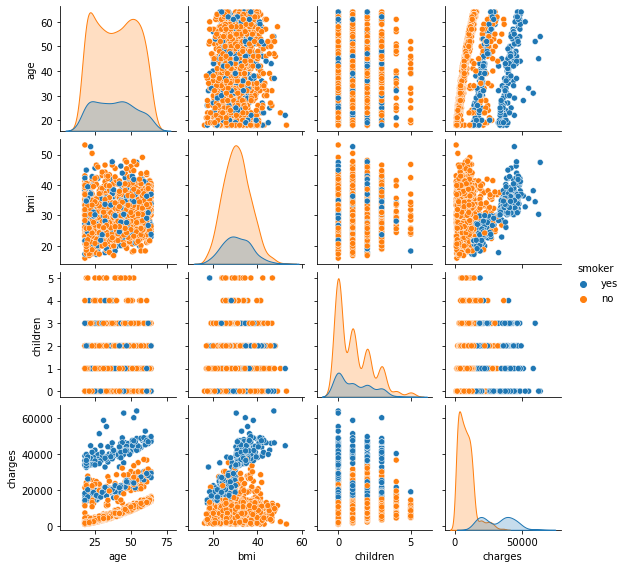

In [7]:
sns.pairplot(df.iloc[:,[0,2,3,4,6]], hue='smoker', diag_kind='kde',height=2)

In [8]:
fig = px.scatter(df, x="bmi", y="charges", color="smoker", facet_col= "region", facet_row= 'sex')
fig.show()

In [9]:
fig = px.scatter(df, x="age", y="charges", color="smoker", facet_col= "region", facet_row= 'sex')
fig.show()

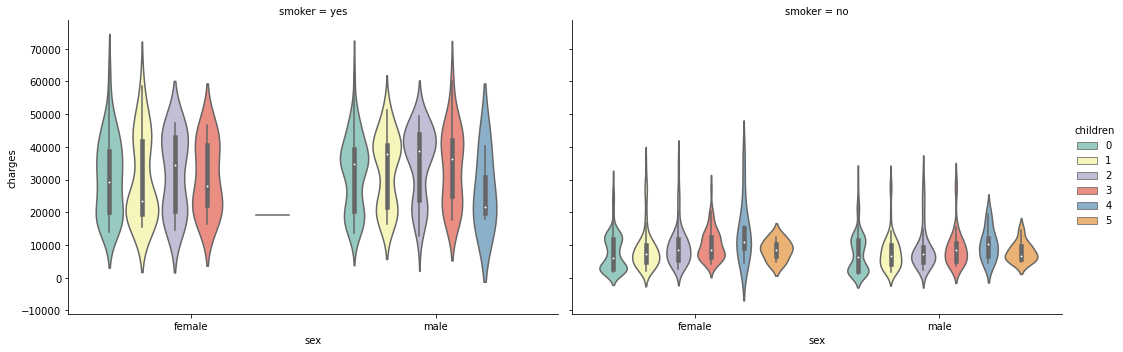

In [10]:
sns.catplot(x="sex", y="charges", hue="children",
                col="smoker", data=df, palette="Set3",
                height=5, aspect=1.5,  kind="violin")

In [11]:
dummies = pd.get_dummies(df[['sex','smoker','region']])
df_dummies = df[['charges','age','bmi','children']].join(dummies)
df_dummies.head()

,charges,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,16884.92400,19,27.900,0,1,0,0,1,0,0,0,1
1,1725.55230,18,33.770,1,0,1,1,0,0,0,1,0
2,4449.46200,28,33.000,3,0,1,1,0,0,0,1,0
3,21984.47061,33,22.705,0,0,1,1,0,0,1,0,0
4,3866.85520,32,28.880,0,0,1,1,0,0,1,0,0


<AxesSubplot:>

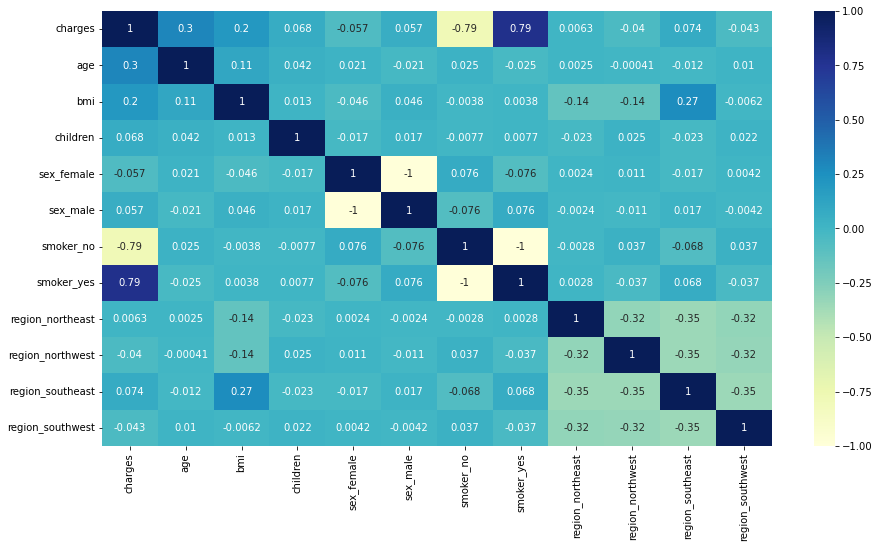

In [12]:
plt.figure(figsize = (15,8))
corr_matrix = df_dummies.corr()
sns.heatmap(corr_matrix, annot=True,cmap='YlGnBu')

In [13]:
corr_matrix["charges"].sort_values(ascending=False)

charges             1.000000
smoker_yes          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_male            0.057292
region_northeast    0.006349
region_northwest   -0.039905
region_southwest   -0.043210
sex_female         -0.057292
smoker_no          -0.787251
Name: charges, dtype: float64

In [14]:
random_state = 42
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = random_state)

# Stratified sampling
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=random_state)
for train_index, test_index in split.split(df, df["smoker"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

def smorker_proportions(data):
    return data['smoker'].value_counts()/len(data)

compare_props = pd.DataFrame({
    'Overall': smorker_proportions(df),
    'Random': smorker_proportions(test_set),
    'Stratied': smorker_proportions(strat_test_set)
})
compare_props['Rand.%error'] = 100*(compare_props['Random'] - compare_props['Overall'])/compare_props['Overall']
compare_props['Strat.%error'] = 100*(compare_props['Stratied'] - compare_props['Overall'])/compare_props['Overall']

compare_props

,Overall,Random,Stratied,Rand.%error,Strat.%error
no,0.795217,0.798507,0.794776,0.413814,-0.055409
yes,0.204783,0.201493,0.205224,-1.606929,0.215165


In [15]:
fitted_data, fitted_lambda = stats.boxcox(strat_train_set['charges'])
strat_train_set['charges_tr']=fitted_data

Text(0.5, 1.0, 'Transformed data')

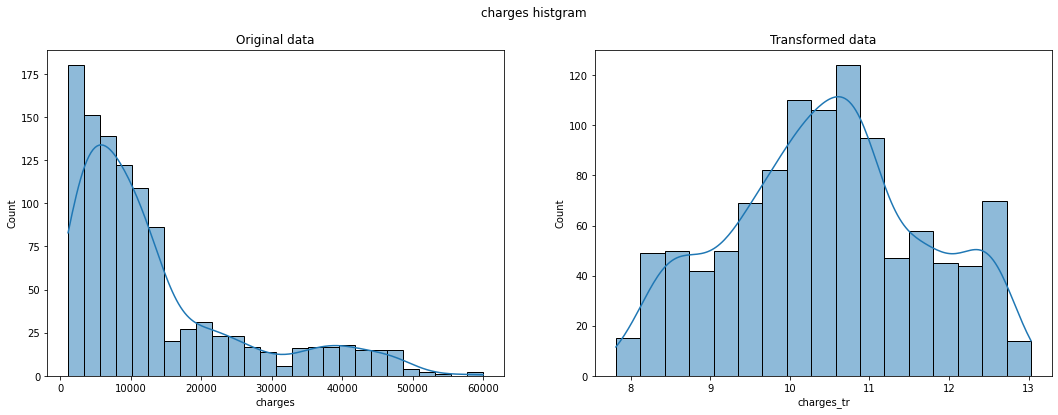

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('charges histgram')

sns.histplot(ax=axes[0], data=strat_train_set, x='charges',kde=True)
axes[0].set_title('Original data')

sns.histplot(ax=axes[1], data=strat_train_set, x='charges_tr', kde=True)
axes[1].set_title('Transformed data')

Text(0.5, 1.0, 'Transformed data')

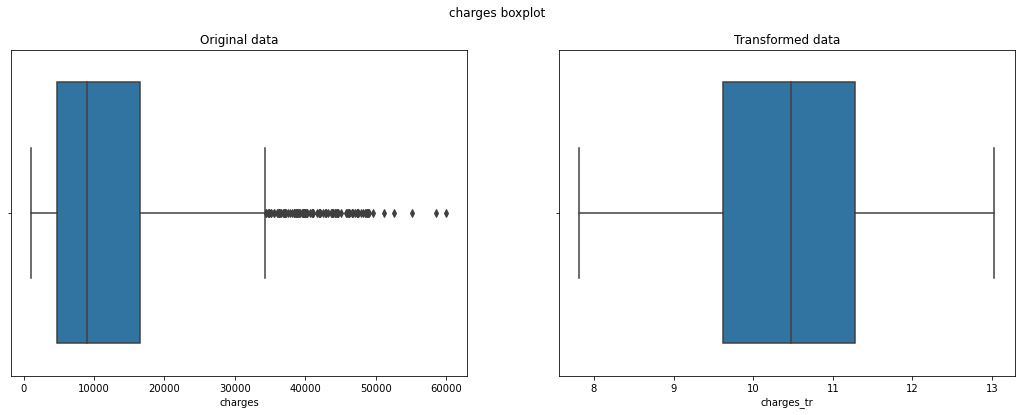

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('charges boxplot')

sns.boxplot(ax=axes[0], data=strat_train_set, x='charges')
axes[0].set_title('Original data')

sns.boxplot(ax=axes[1], data=strat_train_set, x='charges_tr')
axes[1].set_title('Transformed data')

In [18]:
X_train = strat_train_set.drop(['charges','charges_tr'], axis=1)
y_train =  strat_train_set['charges_tr']
strat_test_set['charges_tr']=stats.boxcox(strat_test_set['charges'], fitted_lambda)
X_test = strat_test_set.drop(['charges','charges_tr'], axis=1)
y_test =  strat_test_set['charges_tr']

In [19]:
df_num = X_train[['age','bmi','children']]
scale = RobustScaler()
df_num_tr = scale.fit_transform(df_num)
df_num = pd.DataFrame(df_num_tr, columns=list(df_num),index=df_num.index) 

In [20]:
df_cat = X_train[['sex','smoker','region']]
df_cat_dummies = pd.get_dummies(df_cat)
X_train_tr = df_num.join(df_cat_dummies)
X_train_tr.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
8,-0.083333,-0.042799,0.5,0,1,1,0,1,0,0,0
362,-0.833333,-0.983227,-0.5,1,0,0,1,0,0,0,1
1069,0.625000,0.196645,0.0,1,0,1,0,0,0,1,0
132,0.583333,0.659341,0.5,1,0,1,0,0,0,0,1
213,-0.208333,-0.401388,0.0,1,0,1,0,0,0,1,0


In [21]:
def display_rmse(model, X, y):
    cv_scores = cross_val_score(model, X, y,
                             scoring="neg_mean_squared_error", cv=10)
    scores = np.sqrt(-cv_scores)
    print("CV RMSE:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    return scores, scores.mean(),scores.std()

In [22]:
lin_reg = LinearRegression()
CV_lin, lin_mean, lin_std = display_rmse(lin_reg, X_train_tr, y_train)

CV RMSE: [0.54325886 0.56422517 0.66583375 0.54621298 0.65723494 0.61116552
 0.50007075 0.57075124 0.43408654 0.54160326]
Mean: 0.5634443004029916
Standard deviation: 0.06598684617315874


CV RMSE: [0.54409271 0.56422517 0.66729297 0.54621298 0.65723494 0.61116552
 0.50007075 0.57075124 0.43588701 0.54160326]
Mean: 0.5638536542856606
Standard deviation: 0.06583796231565808
CV RMSE: [0.49211998 0.52531342 0.58385438 0.41930639 0.57830231 0.49775895
 0.32734787 0.40090124 0.35957642 0.47127305]
Mean: 0.46557540064580377
Standard deviation: 0.08288845886488051
CV RMSE: [0.48679241 0.54263335 0.60078964 0.41284597 0.59229035 0.49087112
 0.34466746 0.40319072 0.41448772 0.51798951]
Mean: 0.48065582576830035
Standard deviation: 0.08108113146473131
CV RMSE: [0.56447797 0.62190046 0.67218784 0.48047165 0.7938734  0.7477692
 0.53380488 0.47291775 0.51202461 0.56376976]
Mean: 0.5963197519747904
Standard deviation: 0.10493366331834154
Best degree 2 with RMSE 0.46557540064580377


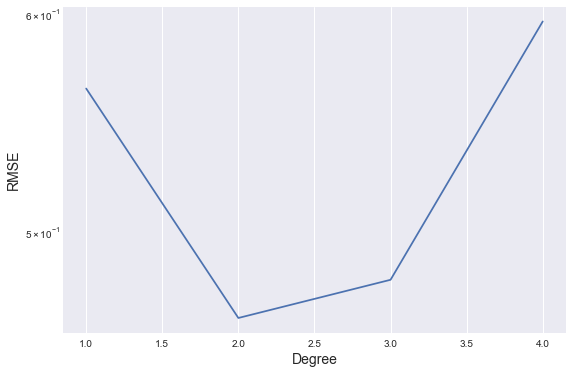

In [23]:
rmses = []
degrees = np.arange(1, 5)
min_rmse, min_deg = 1, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_tr)
    
    # Compare with CV data
    CV_scores, poly_rmse, std = display_rmse(lin_reg, X_poly_train,y_train)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
plt.figure(figsize = (9,6))
plt.style.use('seaborn')
plt.plot(degrees, rmses)
plt.yscale('log')
plt.xlabel('Degree',fontsize = 14)
plt.ylabel('RMSE',fontsize = 14)
plt.show()

In [24]:
def plot_learning_curves(estimator, X, y, train_sizes, cv, name):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, train_sizes =train_sizes, cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = np.sqrt(-train_scores).mean(axis = 1)
    train_scores_std = np.sqrt(-train_scores).std(axis=1)
    validation_scores_mean = np.sqrt(-validation_scores).mean(axis=1)
    validation_scores_std = np.sqrt(-validation_scores).std(axis=1)

    plt.style.use('seaborn')   
    plt.plot(train_sizes, train_scores_mean, "r-+", linewidth=2,label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, "b-", linewidth=3, label = 'Validation error')
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.1,
        color="b",
    )

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + name + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend(loc="best")
    plt.ylim(0,1)

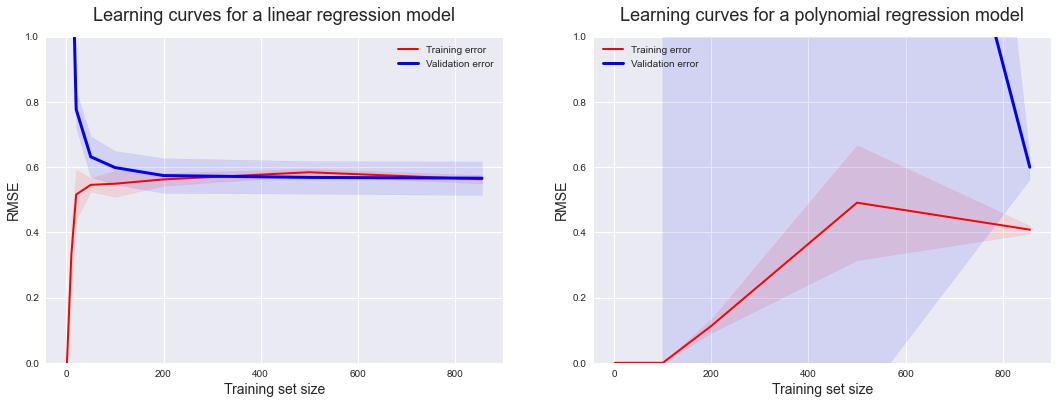

In [25]:
poly2_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly2_train = poly_features.fit_transform(X_train_tr)


plt.figure(figsize = (18,6))
train_sizes = [1, 10, 20, 50, 100, 200, 500, 856]
titles = ['linear regression','polynomial regression']
for X, title,i in [(X_train_tr,titles[0], 1), (X_poly2_train,titles[1],2)]:
    plt.subplot(1,2,i)
    plot_learning_curves(lin_reg, X, y_train, train_sizes, 5, title)


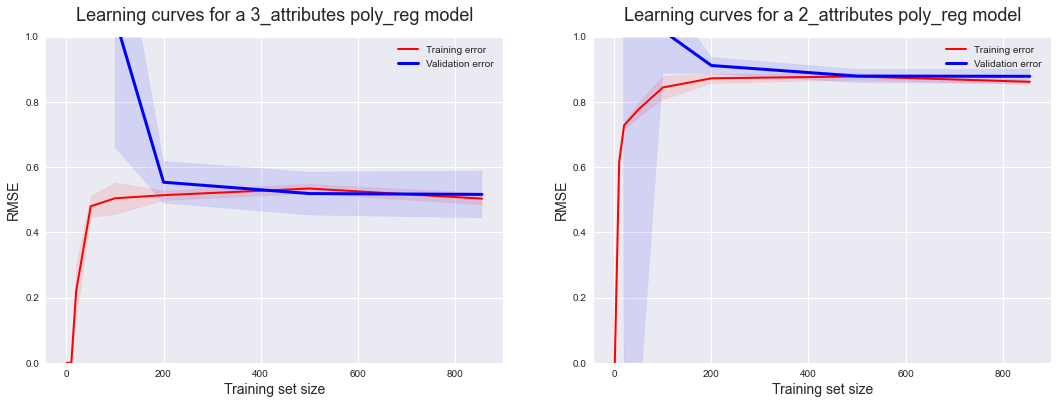

In [27]:
X_poly2_select1 = poly_features.fit_transform(X_train_tr[['smoker_yes','bmi','age']])
X_poly2_select2 = poly_features.fit_transform(X_train_tr[['smoker_yes','bmi']])
titles = ['3_attributes poly_reg','2_attributes poly_reg']
plt.figure(figsize = (18,6))
for X, title,i in [(X_poly2_select1,titles[0], 1), (X_poly2_select2,titles[1],2)]:
    plt.subplot(1,2,i)
    plot_learning_curves(lin_reg, X, y_train, train_sizes, 5, title)

In [28]:
tree_reg = DecisionTreeRegressor()
CV_tree, tree_mean, tree_std = display_rmse(tree_reg, X_train_tr, y_train)

CV RMSE: [0.54428819 0.62960323 0.71043609 0.51413729 0.76809505 0.59887315
 0.62812314 0.61476475 0.62703748 0.48862869]
Mean: 0.6123987056359679
Standard deviation: 0.08025716817015406


In [29]:
parameters ={'n_estimators': [100, 150, 200, 300],'max_leaf_nodes': list(range(20,40,2))}
forest_reg = RandomForestRegressor(random_state=random_state)
grid_search = GridSearchCV(estimator=forest_reg,
                           param_grid=parameters,
                           scoring= 'neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
best_parameters = grid_search.best_params_
best_result = grid_search.best_score_
f_i = grid_search.best_estimator_.feature_importances_
print('The best parameters for classifier is', best_parameters)
print('The RMSE score is %.3f:'% np.sqrt(-grid_search.best_score_))

The best parameters for classifier is {'max_leaf_nodes': 34, 'n_estimators': 150}
The RMSE score is 0.475:


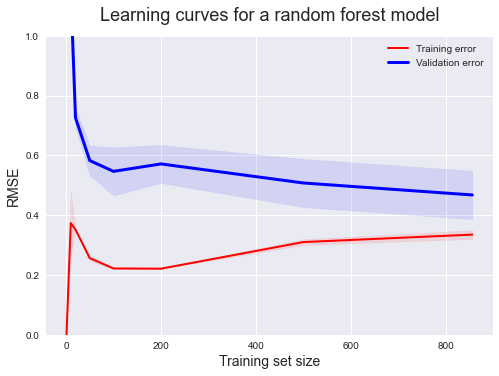

In [30]:
randf_reg = grid_search.best_estimator_
plot_learning_curves(randf_reg, X_train_tr, y_train,train_sizes, 5, name='random forest')

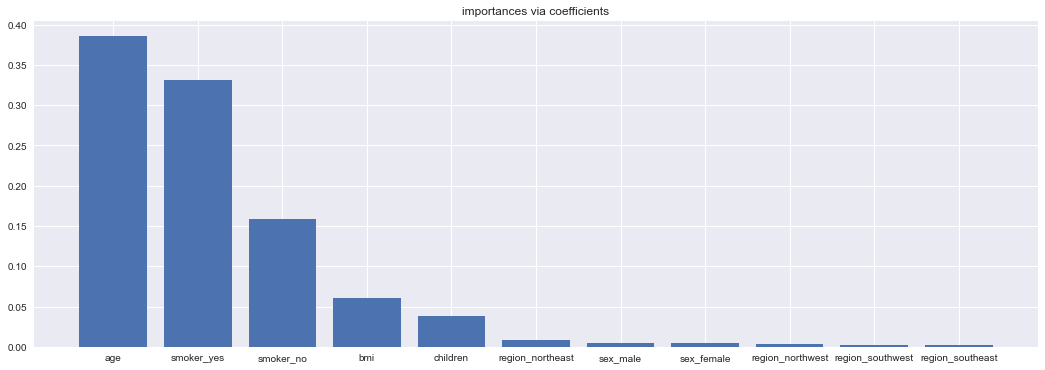

In [31]:
features = list(X_train_tr.columns)
f_rf = list(zip(features,f_i))
f_rf.sort(key = lambda x : x[1],reverse=True)

plt.figure(figsize = (18,6))
plt.bar(x=[x[0] for x in f_rf],height=[x[1] for x in f_rf])
plt.title("importances via coefficients")
plt.show()

In [32]:
y_test_tr = stats.boxcox(y_test,fitted_lambda)
y_test_tr

num_test = scale.fit_transform(X_test[['age','bmi','children']])
num_test = pd.DataFrame(num_test, columns=['age','bmi','children'],index=X_test.index) 
cat_test = X_test[['sex','smoker','region']]
cat_test_dummies = pd.get_dummies(cat_test)
X_test_tr = num_test.join(cat_test_dummies)
X_test_tr.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
750,-0.133333,-0.582130,-0.5,1,0,0,1,0,0,1,0
790,-0.057143,1.373115,-0.5,1,0,1,0,0,0,1,0
711,0.361905,-0.945247,0.5,1,0,1,0,0,0,1,0
108,-0.438095,-0.386605,-0.5,0,1,1,0,0,0,1,0
391,-0.819048,0.818283,-0.5,1,0,1,0,0,1,0,0


In [33]:
y_pred_randf = randf_reg.predict(X_test_tr)
mse_randf = mean_squared_error(y_test_tr, y_pred_randf)
rmse_randf = np.sqrt(mse_randf)
print('RMSE:%.3f'% rmse_randf)

RMSE:8.067


In [34]:
y_pred = inv_boxcox(y_pred_randf, fitted_lambda)
df_result = pd.DataFrame({'predicted':y_pred},index=y_test.index)
df_result = strat_test_set[['smoker','charges']].join(df_result)
df_result.head()

,smoker,charges,predicted
750,yes,19539.2430,19420.109353
790,no,5662.2250,6403.629576
711,no,10107.2206,10160.064269
108,no,2867.1196,2806.679121
391,no,2138.0707,2079.846794


In [35]:
fig = px.scatter(df_result, x='charges', y='predicted', color='smoker')
fig.add_shape(type='line', line=dict(dash='dash'),
              x0= df_result['charges'].min(), x1=  df_result['charges'].max(), y0=  df_result['charges'].min(), y1=  df_result['charges'].max())
fig.show()

In [36]:
df_result['residuals'] = df_result['charges']-df_result['predicted']

fig = make_subplots(
     rows=1, cols=2,
     specs=[[{"type": "scatter"}, {"type": "histogram"}]]
     )
    
fig.add_trace(go.Scatter(x=list(np.arange(1,df_result.shape[0]+1,1)),y=df_result['residuals'],mode='markers'),row=1, col=1)    
fig.add_trace(go.Histogram(x= df_result['residuals'],nbinsx=50),row=1, col=2)
fig.update_xaxes(title_text='Index',row=1, col=1)
fig.update_yaxes(title_text='Residuals', row=1, col=1)
fig.update_xaxes(title_text="Residuals", row=1, col=2)
fig.update_yaxes(title_text='Count', row=1, col=2)
fig.update_layout(title = 'Residuals')
fig.show()